In [325]:
%matplotlib inline

In [361]:
from IPython.core.debugger import set_trace
from collections import defaultdict
import math

# replace a list of items with a list of new_items in list words
def replace_features(words, items, new_items):
    for i, _ in enumerate(items):
        words[words.index(items[i])]=new_items[i]
    return words

class House(object):
    """NYC Data Science Academy Project 3 - House Price Prediction"""
    def __init__(self, train_file, test_file, describe_file):
        self.train_data = pd.read_csv(train_file, na_values='')
        self.test_data = pd.read_csv(test_file, na_values='')
        self.desc_file = describe_file
        self.feature_names = defaultdict(list)
        
    def train_head(self,n=5):
        print(self.train_data.head(n))
        
    def test_head(self,n=5):
        print(self.test_data.head(n))
        
    def train_shape(self):
        print(self.train_data.shape)
        
    def test_shape(self):
        print(self.test_data.shape)
        
    def train_info(self):
        print(self.train_data.info())
        
    def test_info(self):
        print(self.test_data.info())
        
    # parse description file
    def parse_features(self):
        with open(self.desc_file, 'r') as file:
            item = ''
            lines = file.readlines()
            for line in lines:
                # check empty line
                line_stripped = line.strip()
                if line_stripped: 
                    if line_stripped.find(':',0,min(20, len(line_stripped))) != -1:
                        item = line_stripped.split(':')[0]
                    else:
                        level = line_stripped.split('\t')[0]
                        self.feature_names[item].append(level)
                            
    # check the differences between description file and dataset                        
    def check_features(self):
        # check each features
        for feature in self.feature_names:
            # check features against columns in train data
            if feature in (self.train_data.columns):
                # check the number of levels in feature
                # skip the check if the levels are numeric
                if  self.feature_names[feature] != None and (not self.feature_names[feature][0].isnumeric()):
                    diff = set(self.train_data[feature]).difference(set(self.feature_names[feature]))
                    # ignore the difference if it is of type nan or NA
                    if len(diff) and not (len(diff) == 1 and (np.nan in diff)):
                        print('%s:'%feature)
                        print('\ntrain: ', set(self.train_data[feature]))
                        print('\ndescription: ', set(self.feature_names[feature]))
                        print('\ndifference: ', diff, '\n\n')
            else:
                print('%s is not in the dataset.\n\n' % feature)
                
    # manually reconcile feature difference 
    def reconcile_features(self):
        self.feature_names['MSZoning']=replace_features(self.feature_names['MSZoning'],
                                                       ['C'],['C (all)'])
        self.feature_names['Neighborhood']=replace_features(self.feature_names['Neighborhood'],
                                                       ['Names'],['NAmes'])
        self.feature_names['BldgType']=replace_features(self.feature_names['BldgType'],
                                                       ['Duplx','TwnhsI','2FmCon'],
                                                       ['Duplex', 'Twnhs', '2fmCon'])
        self.feature_names['Exterior2nd']=replace_features(self.feature_names['Exterior2nd'],
                                                       ['CemntBd','BrkComm'],
                                                       ['CmentBd','Brk Cmn'])
        self.feature_names['Exterior2nd'].append('Wd Shng')
        self.feature_names['SaleType']=replace_features(self.feature_names['SaleType'],
                                                       ['WD '],['WD'])
#        self.feature_names['BedroomAbvGr']=['0','1','2','3','4','5','6','7','8']
#        self.feature_names['KitchenAbvGr']=['0','1','2','3']
        
    # convert column training data to proper data type
    def convert_train(self):
        for feature in (self.train_data.columns):
            if feature in self.feature_names:
                self.train_data[feature].astype(pd.api.types.CategoricalDtype(categories=self.feature_names[feature]))
            else:
                self.train_data[feature].astype('int', errors='ignore')
                
    # convert column testing data to proper data type
    def convert_test(self):
        for feature in (self.test_data.columns):
            if feature in self.feature_names:
                self.test_data[feature].astype(pd.api.types.CategoricalDtype(categories=self.feature_names[feature]))
            else:
                self.test_data[feature].astype('int', errors='ignore')
                
    # Sales Histogram
    def sales_hist(self):
        fig, axes = plt.subplots(1,2, figsize=(14,6))
        self.train_data['SalePrice'].plot.hist(bins=20, ax=axes[0])
        axes[0].set_xlabel('House Price')
        pd.Series(map(math.log,self.train_data['SalePrice']+1)).plot.hist(bins=20, ax=axes[1])
        axes[1].set_xlabel('House Price - Log Scale')
        plt.show()


In [363]:
house = House('./dataset/train.csv', './dataset/test.csv', 
              './dataset/data_description.txt')
house.parse_features()
house.reconcile_features()
house.convert_train()
house.convert_test()

/Users/msun/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/internals.py:594: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
/Users/msun/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/internals.py:594: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))


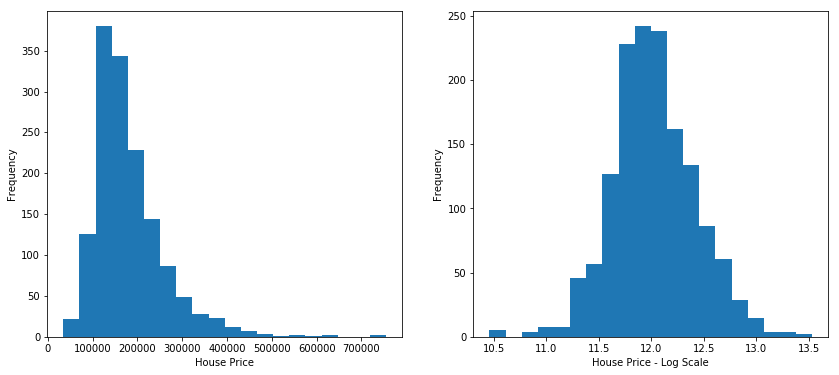

In [365]:
house.sales_hist()